In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns

from bisect import bisect_left

In [ ]:
class Setup1D:
    def __init__(self, setup_type='ball'):
        """
        Creates Prox-setup object, having DGF, DGF_grad, norm and dual_norm methods.
        Each function assumes its' argument z is 1-d
        :param: setup_type - must by either 'ball', 'entropy' or 'bilinear-ssp-entropy'
        """
        self.setup_type = setup_type
        self.delta = 1e-12

        if setup_type not in ['ball', 'entropy']:
            raise ValueError("Setup type not supported, it must be either 'ball' or 'entropy'")
    

    def norm(self, z):
        return np.linalg.norm(z, ord=(2 if self.setup_type == 'ball' else 1))
    
    def dual_norm(self, xi):
        return np.linalg.norm(xi, ord=(2 if self.setup_type == 'entropy' else np.inf))
    

    def DGF(self, z):
        if self.setup_type == 'ball':
            return np.linalg.norm(z, ord=2) / 2
        z_reg = z + self.delta / len(z)
        return (1 + self.delta) * np.sum(z_reg * np.log(z_reg))

    def DGF_grad(self, z):
        if self.setup_type == 'ball':
            return z
        return (1 + self.delta) * (1 + np.log(z + self.delta / len(z)))


    def bregman_divergence(self, z, z0):
        return self.DGF(z) - self.DGF(z0) - np.dot(self.DGF_grad(z0), z - z0)
        

    def prox(self, z0, xi):
        # prox_z0(xi) = argmin_z(np.dot(xi, z) + self.bregman_divergence(xi, z))
        # prox_z0(xi) = argmin_z(np.dot(xi, z) + DGF(z) - np.dot(DGF_grad(z0), z))
        # xi + DGF_grad(z) - DGF_grad(z0) = 0
        # z: DGF_grad(z) = DGF_grad(z0) - xi

        if self.setup_type == 'ball':
            # DGF_grad(z) = z
            return self.DGF_grad(z0) - xi
        
        # DGF_grad(z) = (1 + delta) * (1 + ln(z + delta / n))
        v = np.exp((self.DGF_grad(z0) - xi) / (1 + self.delta) - 1)
        return (1 + self.delta) * v / self.norm(v) - self.delta / len(z0)

In [ ]:
class EntropySetup2D:
    def __init__(self, m, n):
        '''
        Entropy setup for 2-d optimization problems
        Each function assumes argument's is tuple of m and n dimensional vectors
        '''
        self.entropy_setup = Setup1D('entropy')
        self.delta = self.entropy_setup.delta
        self.m, self.n = m, n

        n_log_sqrt, m_log_sqrt = np.sqrt(np.log(n)), np.sqrt(np.log(m))
        self.alpha = 1 / (n_log_sqrt * (n_log_sqrt + m_log_sqrt))
        self.beta = 1 / (m_log_sqrt * (n_log_sqrt + m_log_sqrt))
    
    def norm(self, z):
        return np.sqrt(
            self.alpha * np.square(self.entropy_setup.norm(z[0])) + 
            self.beta * np.square(self.entropy_setup.norm(z[1]))
        )
    
    def dual_norm(self, f):
        return np.sqrt(
            np.square(self.entropy_setup.dual_norm(f[0])) / self.alpha +
            np.square(self.entropy_setup.dual_norm(f[1])) / self.beta
        )
    

    def DGF(self, z):
        return self.alpha * self.entropy_setup.DGF(z[0]) + self.beta * self.entropy_setup.DGF(z[1])

    def DGF_grad(self, z):
        # alpha = 1 / np.log(z[0].shape[0]) ?
        # beta = 1 / np.log(z[1].shape[1]) ?
        return self.alpha * self.entropy_setup.DGF_grad(z[0]), self.beta * self.entropy_setup.DGF_grad(z[1])
    
    def prox(self, z0, xi):
        DGF_grad = self.DGF_grad(z0)
        v = np.exp((DGF_grad[0] - xi[0]) / (1 + self.delta) - 1), np.exp((DGF_grad[1] - xi[1]) / (1 + self.delta) - 1)

        # To project on the simplex we've got to divide on the L1-norm
        return (
            (1 + self.delta) * v[0] / (np.linalg.norm(v[0], ord=1)) - self.delta / len(z0[0]),
            (1 + self.delta) * v[1] / (np.linalg.norm(v[1], ord=1)) - self.delta / len(z0[1])
        )

In [ ]:
class Scheduler:
    def __init__(self, lr):
        self.lr = lr
        self.step = 0
    
    def __call__(self):
        pass
    
    def get_params(self):
        return self.__dict__.items()
    
    def compute_step_lr(self, step):
        pass


class ExponentialScheduler(Scheduler):
    def __init__(self, lr, lr_mult=0.9):
        super().__init__(lr)
        self.lr_mult = lr_mult
    
    def __call__(self):
        self.step += 1
        lr = self.lr
        self.lr *= self.lr_mult
        return lr
    
    def compute_step_lr(self, step):
        return np.power(self.lr_mult, step) * self.lr

class DoubleLinearScheduler(Scheduler):
    def __init__(self, lr, n, m=None, subgradient_constant=1.0):
        super().__init__(lr)
        self.const1 = np.sqrt(np.log(n)) / subgradient_constant
        self.const2 = np.sqrt(np.log(m)) / subgradient_constant if m else self.const1
        self.lr = self.const1, self.const2
    
    def __call__(self):
        self.step += 1
        self.lr = self.const1 / np.sqrt(self.step), self.const2 / np.sqrt(self.step)
        return self.lr
    
    def compute_step_lr(self, step):
        return self.const1 / np.sqrt(step), self.const2 / np.sqrt(step)

In [ ]:
def random_index(n, probas_cumsum):
    random_prob = np.random.rand()
    v = bisect_left(probas_cumsum, random_prob, 0, n)
    return v

In [ ]:
def duality_gap(A, x, y):
    return np.max(A @ x), np.min(A.T @ y) 

def distance_squared(x, y, x_opt, y_opt):
    return np.linalg.norm(np.hstack([x, y]) - np.hstack(([x_opt, y_opt])), ord=1)

In [ ]:
class SaddlePointMirrorDescentOptimizer:
    def __init__(self, scheduler: Scheduler = DoubleLinearScheduler(lr=1., n=10), 
                 tolerance: float = 1e-6, max_steps: int = 1000, 
                 stochastic: bool = True, stochastic_projection: bool = False, 
                 polyak_optimized: bool = False, linear_proj: bool = True, softmax_proj: bool = False):

        self.scheduler = scheduler
        self.tolerance = tolerance
        self.max_steps = max_steps

        self.stochastic = stochastic
        self.stochastic_projection = stochastic_projection
        self.polyak_optimized = polyak_optimized
        self.sigma_min = None
        self.sigma_max = None
        self.linear_proj = linear_proj
        self.softmax_proj = softmax_proj

    @staticmethod
    def deterministic_oracle(A, x, y):
        return [A.T @ y, -A @ x]

    @staticmethod
    def stochastic_matvec(A, x):
        x_norm, x_abs = np.linalg.norm(x, ord=1), np.abs(x)
        random_column_index = random_index(A.shape[1], x_abs)
        x_index_sign = np.sign(x[random_column_index])
        return x_norm * x_index_sign * A[random_column_index]
    
    @staticmethod
    def stochastic_simplex_matvec(A, x):
        random_column_index = random_index(A.shape[1], np.cumsum(x))
        return A[:, random_column_index]

    @staticmethod
    def stochastic_oracle(A, x, y):
        return [
            SaddlePointMirrorDescentOptimizer.stochastic_simplex_matvec(A.T, y),
            -SaddlePointMirrorDescentOptimizer.stochastic_simplex_matvec(A, x)
        ]
    
    
    def oracle(self, A, x, y, lr):
        # print(f'x: {x}\ny: {y}\ndeterministic_oracle: {self.deterministic_oracle(A, x, y)}\nstochastic_oracle: {self.stochastic_oracle(A, x, y)}\n')
        oracle_call = self.stochastic_oracle(A, x, y) if self.stochastic else self.deterministic_oracle(A, x, y)
        
        if self.polyak_optimized:
            x_shifted = x - oracle_call[0] / lr[0]
            y_shifted = y - oracle_call[1] / lr[1]
            
            if self.softmax_proj:
                x_shifted = np.exp(x_shifted) / np.linalg.norm(np.exp(x_shifted), ord=1)
                y_shifted = np.exp(y_shifted) / np.linalg.norm(np.exp(y_shifted), ord=1)
            elif self.linear_proj:
                x_shifted /= np.linalg.norm(x_shifted, ord=1)
                y_shifted /= np.linalg.norm(y_shifted, ord=1)

            shifted_oracle_call = self.stochastic_oracle(A, x_shifted, y_shifted) if self.stochastic else self.deterministic_oracle(A, x_shifted, y_shifted)
            oracle_call = shifted_oracle_call[0] - lr[0] * oracle_call[0], shifted_oracle_call[1] - lr[1] * oracle_call[1]

        return lr[0] * oracle_call[0], lr[1] * oracle_call[1]

    def fit(self, A, x0=None, y0=None):
        """
        Optimizes min_{x in R^n} max_{y in R^m} y.T @ A @ x
        """
        m, n = A.shape
        entropy_setup = EntropySetup2D(n, m)
        
        x = x0 if x0 is not None else np.ones(n) / n
        y = y0 if y0 is not None else np.ones(m) / m
        x_sum, y_sum = x, y
        x_diff, y_diff = 0, 0
        lr_sum = 1., 1.

        Xs, Ys = [x], [y]
        losses = [y.T @ A @ x]
        duality_gaps = [duality_gap(A, x, y)]

        if self.polyak_optimized:
            sigma_min = np.linalg.norm(A, ord=-2)
            sigma_max = np.linalg.norm(A, ord=2)

            alpha = (2 / (sigma_min + sigma_max)) ** 2
            beta = ((sigma_max - sigma_min) / (sigma_min + sigma_max)) ** 2

        for step in range(1, self.max_steps + 1):
            lr = self.scheduler()
            if not isinstance(lr, tuple):
                lr = lr, lr
            lr_sum = lr_sum[0] + lr[0], lr_sum[1] + lr[1]
            
            oracle_call = self.oracle(A, x, y, lr)

            if self.polyak_optimized:
                oracle_call = alpha * oracle_call[0] - beta * x_diff, alpha * oracle_call[1] - beta * y_diff
            
            x_new, y_new = entropy_setup.prox((x, y), oracle_call)
            x_diff, y_diff = x_new - x, y_new - y
            x, y = x_new, y_new
            
            # print(f'x: {x}\ny: {y}\n')

            if self.stochastic_projection:
                px, py = np.cumsum(x) / np.sum(x), np.cumsum(y) / np.sum(y)
                x, y = np.zeros(n), np.zeros(m)
                x[random_index(n, px)], y[random_index(m, py)] = 1., 1.

                # print(f'px: {px}\npy: {py}\n\n')

            # x = (x_sum := (x_sum + lr[0] * x)) / lr_sum[0] # (step + 1)
            # y = (y_sum := (y_sum + lr[1] * y)) / lr_sum[1] # (step + 1)
            x = (x_sum := (x_sum + x)) / (step + 1)
            y = (y_sum := (y_sum + y)) / (step + 1)
            Xs.append(x)
            Ys.append(y)

            losses.append(y.T @ A @ x)
            duality_gaps.append(duality_gap(A, x, y))

            # if np.linalg.norm(losses[-1] - losses[-2]) < self.tolerance:
            #     break

        return Xs, Ys, losses, duality_gaps

In [ ]:
m, n = 10, 10
A = np.random.normal(size=(m, n))
sigma_min = np.linalg.norm(A, ord=-2)
sigma_max = np.linalg.norm(A, ord=2)
sigma_min, sigma_max

(0.03553262671807928, 6.310709383209449)

In [ ]:
MD_optim = SaddlePointMirrorDescentOptimizer(stochastic=False, stochastic_projection=True, max_steps=100)
Xs, Ys, losses = MD_optim.fit(A, x0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), y0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
x, y = np.array(sum(Xs) / len(Xs)), np.array(sum(Ys) / len(Ys))
assert np.isclose(x.sum(), 1., atol=1e-2) and np.isclose(y.sum(), 1., atol=1e-2), f'Points not on simplices: {x.sum()}, {y.sum()}'

for i, (x, y, loss) in enumerate(zip(Xs, Ys, losses)):
    print(f'{i}-th step:\nx: {x}\ny: {y}\nloss: {loss}\n')

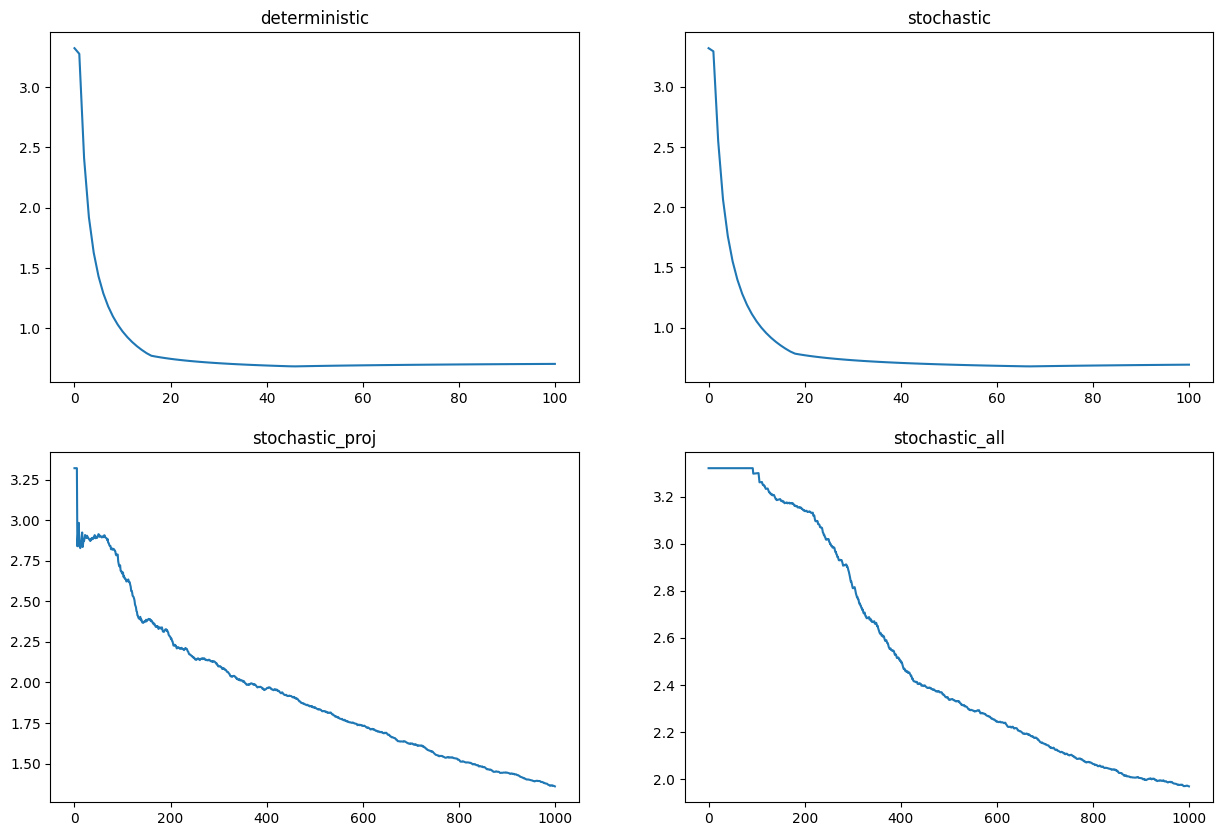

In [ ]:
m, n = 10, 10
A = np.random.normal(size=(m, n))

x0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

params_grid = {
    'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': 100},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': 100},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True},
}

fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
for i, (name, params) in enumerate(params_grid.items()):
    MD_optim = SaddlePointMirrorDescentOptimizer(**params)
    Xs, Ys, losses, duality_gaps = MD_optim.fit(A, x0, y0)
    axes[i // 2][i % 2].plot(duality_gaps)
    axes[i // 2][i % 2].set_title(name)

plt.show()


Optimizing f(x, y) = y.T @ A @ x on simplices, testing by generating matrix A n_starts=100 times.
A is sampled from standard normal distribution, measuring duality gaps for each iteration.


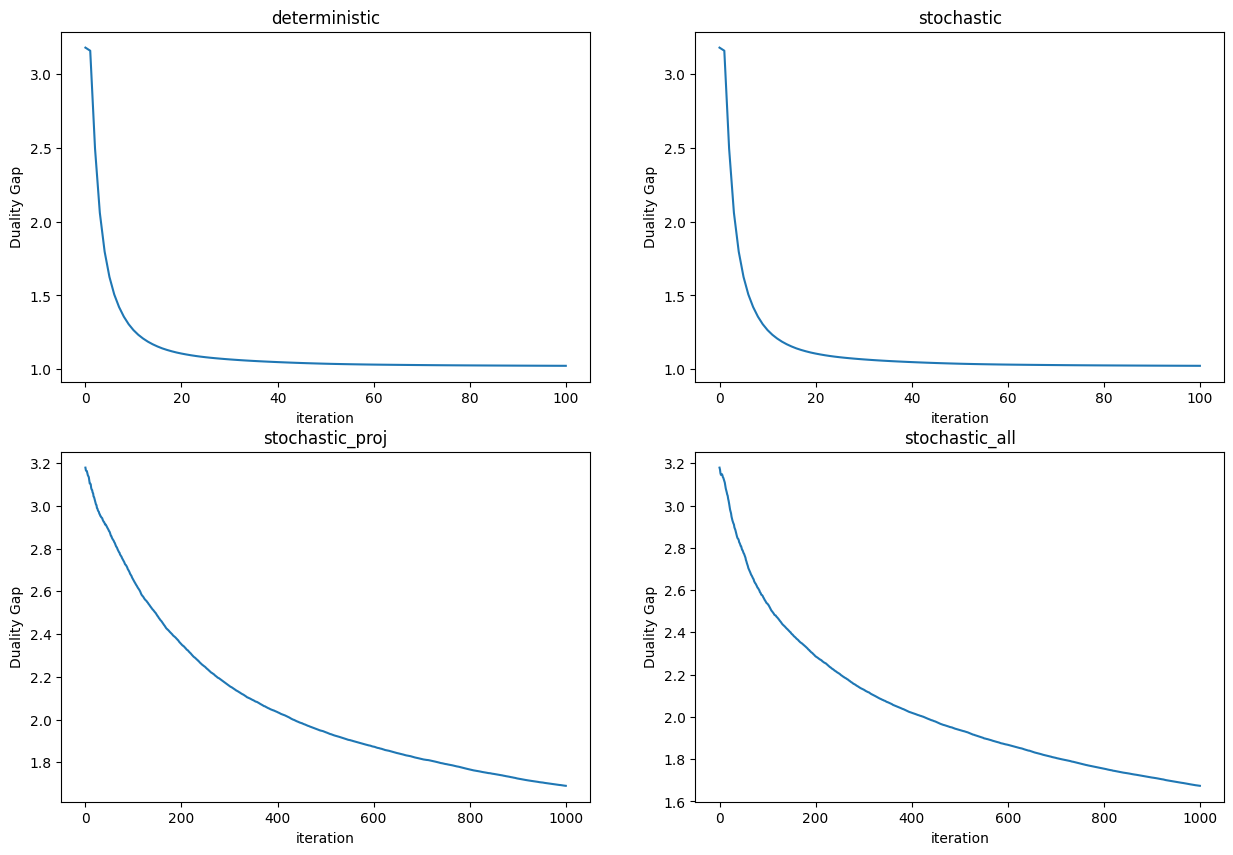

In [ ]:
m, n = 10, 10
n_starts = 100

x0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

params_grid = {
    'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': 100},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': 100},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': 1000},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': 1000},
}
losses = {
    'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)]
}
duality_gaps = {
    'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)]
}

fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
print(f'Optimizing f(x, y) = y.T @ A @ x on simplices, testing by generating matrix A n_starts={n_starts} times.')
print('A is sampled from standard normal distribution, measuring duality gaps for each iteration.')

for start in range(n_starts):
    A = np.random.normal(size=(m, n))
    for i, (name, params) in enumerate(params_grid.items()):
        method_losses = losses[name]
        method_gaps = duality_gaps[name]

        MD_optim = SaddlePointMirrorDescentOptimizer(**params)
        Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0, y0)

        for j, (loss, gap) in enumerate(zip(cur_losses, cur_gaps)):
            method_losses[j] += np.abs(loss)
            method_gaps[j] += gap


for i, (name, params) in enumerate(params_grid.items()):
    losses[name] = [loss / n_starts for loss in losses[name]]
    duality_gaps[name] = [gap / n_starts for gap in duality_gaps[name]]

    axes[i // 2][i % 2].plot(duality_gaps[name])
    axes[i // 2][i % 2].set_title(name)
    axes[i // 2][i % 2].set_ylabel('Duality Gap')
    axes[i // 2][i % 2].set_xlabel('iteration')

plt.show()

Optimizing f(x, y) = y.T @ A @ x on simplices, testing by generating matrix A n_starts=100 times.
A is sampled from standard normal distribution, so mean(abs(f(x, y))) -> 0 as n_starts -> infty


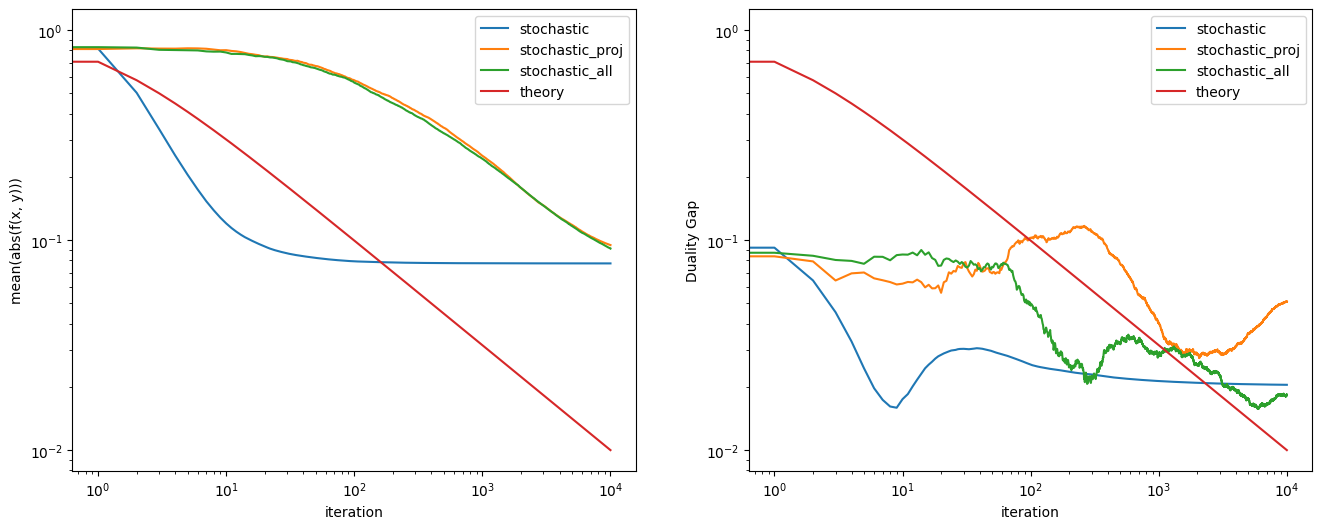

In [ ]:
m, n = 10, 10
n_starts = 100
max_steps = 10000

x0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y0=np.array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

params_grid = {
    # 'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps},
}
losses = {
    # 'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)]
}
duality_gaps = {
    # 'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)]
}

fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
print(f'Optimizing f(x, y) = y.T @ A @ x on simplices, testing by generating matrix A n_starts={n_starts} times.')
print('A is sampled from standard normal distribution, so mean(abs(f(x, y))) -> 0 as n_starts -> infty')

for start in range(n_starts):
    A = np.random.normal(size=(m, n))
    for i, (name, params) in enumerate(params_grid.items()):
        method_losses = losses[name]
        method_duality_gaps = duality_gaps[name]

        MD_optim = SaddlePointMirrorDescentOptimizer(**params)
        Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0, y0)

        for j in range(len(cur_losses)):
            method_losses[j] += np.abs(cur_losses[j])
            method_duality_gaps[j] += cur_gaps[j]
            
for i, (name, params) in enumerate(params_grid.items()):
    losses[name] = [loss / n_starts for loss in losses[name]]
    duality_gaps[name] = [dg / n_starts for dg in duality_gaps[name]]

    axes[0].plot(losses[name], label=name)
    axes[1].plot(duality_gaps[name], label=name)

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()


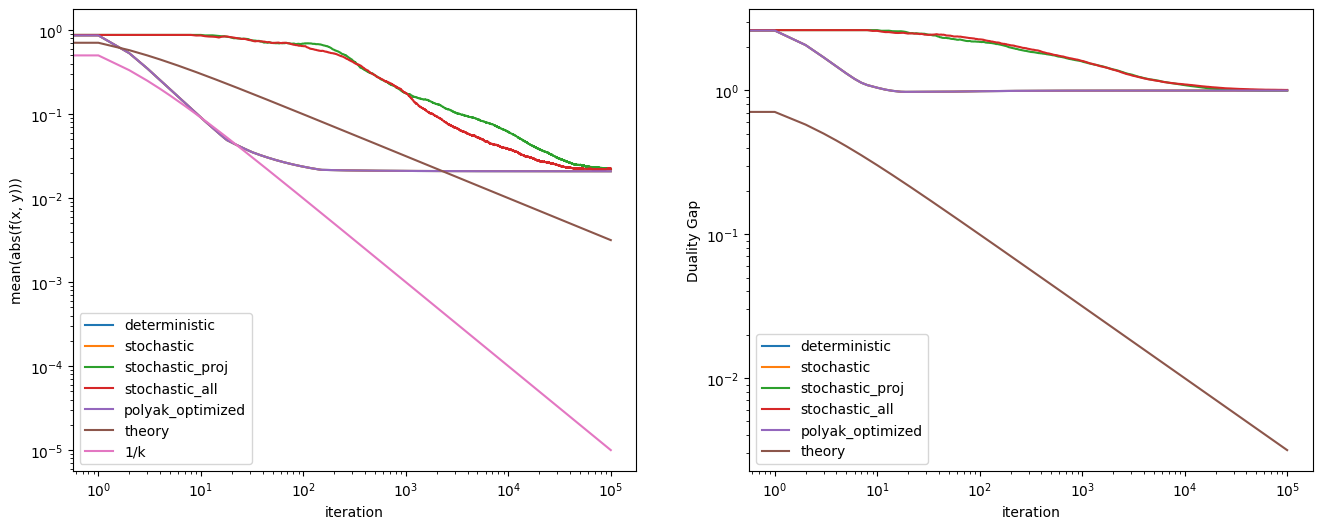

In [ ]:
n_starts = 10
max_steps = 100000

params_grid = {
    'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},# 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps},# 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps},# 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps},# 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))},
    'polyak_optimized': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},# 'polyak_optimized': True, 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))}
}
losses = {
    'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)],
    'polyak_optimized': [0. for _ in range(params_grid['polyak_optimized']['max_steps'] + 1)]
}
duality_gaps = {
    'deterministic': [[0., 0.] for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [[0., 0.] for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [[0., 0.] for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [[0., 0.] for _ in range(params_grid['stochastic_all']['max_steps'] + 1)],
    'polyak_optimized': [[0., 0.] for _ in range(params_grid['polyak_optimized']['max_steps'] + 1)]
}


fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

for start in range(n_starts):
    x0 = np.zeros(A.shape[1])
    y0 = np.zeros(A.shape[0])
    x0[np.random.choice(x0.shape[0])] += 1.
    # x0[np.random.choice(x0.shape[0])] += 0.1
    # x0[np.random.choice(x0.shape[0])] += 0.1
    y0[np.random.choice(y0.shape[0])] += 1.
    # y0[np.random.choice(y0.shape[0])] += 0.1
    # y0[np.random.choice(y0.shape[0])] += 0.1

    for i, (name, params) in enumerate(params_grid.items()):
        method_losses = losses[name]
        method_duality_gaps = duality_gaps[name]

        MD_optim = SaddlePointMirrorDescentOptimizer(**params)
        Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0=x0, y0=y0)

        for j in range(len(cur_losses)):
            method_losses[j] += np.abs(cur_losses[j])
            method_duality_gaps[j][0] += cur_gaps[j][0]
            method_duality_gaps[j][1] += cur_gaps[j][1]

for i, (name, params) in enumerate(params_grid.items()):
    losses[name] = [loss / n_starts for loss in losses[name]]
    duality_gaps[name] = [[dg[0] / n_starts, dg[1] / n_starts] for dg in duality_gaps[name]]

    axes[0].plot(losses[name], label=name)
    axes[1].plot([duality_gap[0] - duality_gap[1] for duality_gap in duality_gaps[name]], label=name)

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()


In [ ]:
MD_optim.scheduler.lr

(0.0006169218567650103, 0.0006169218567650103)

In [ ]:
optimal_loss = ((np.ones(A.shape[0]) / A.shape[0]) @ A @ (np.ones(A.shape[1]) / A.shape[1]))
optimal_duality_gap = np.max(A @ (np.ones(A.shape[1]) / A.shape[1])) - np.min(A.T @ (np.ones(A.shape[0]) / A.shape[0]))
suboptimal_duality_gap = np.max(A @ np.array([0.8, 0., 0., 0., 0., 0.1, 0.1, 0., 0., 0.])) - np.min(A.T @ np.array([0., 0., 0., 0., 0., 0.8, 0.1, 0.1, 0., 0.]))
optimal_duality_gap, suboptimal_duality_gap

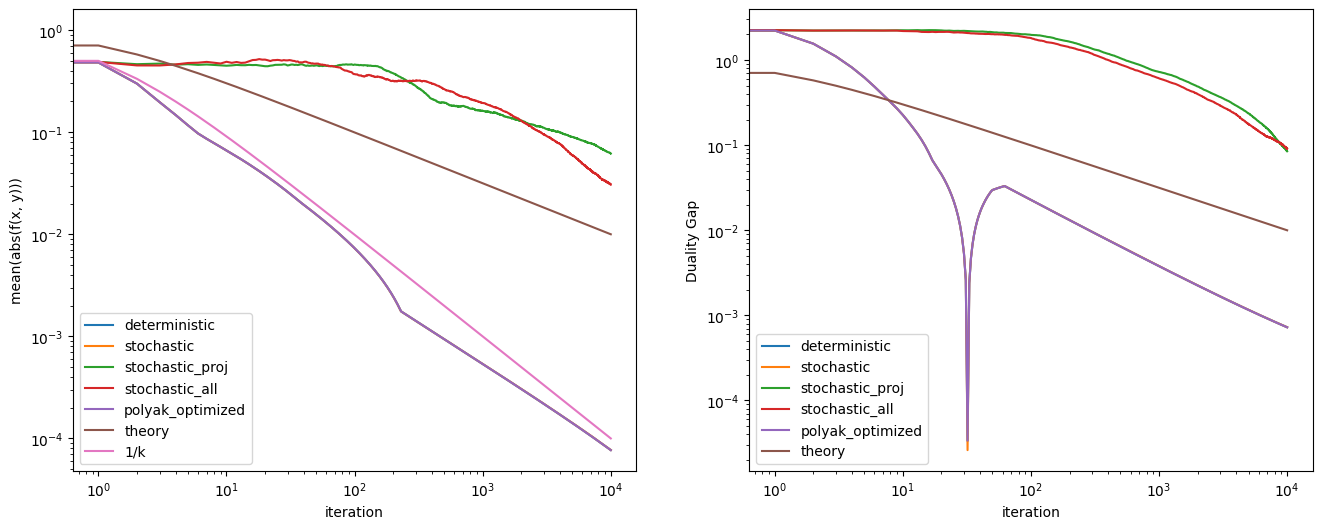

In [ ]:
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

optimal_duality_gap = np.max(A @ (np.ones(A.shape[1]) / A.shape[1])) - np.min(A.T @ (np.ones(A.shape[0]) / A.shape[0]))

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(losses[name] - optimal_loss, label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1] - optimal_duality_gap) for duality_gap in duality_gaps[name]], label=name)

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()

In [ ]:
((np.ones(A.shape[0]) / A.shape[0]) @ A @ (np.ones(A.shape[0]) / A.shape[0]))

0.020904782430651435

In [ ]:
Ys[-1] @ A @ Xs[-1], Xs[-1], Ys[-1]

(0.021411423972306585,
 array([0.09987071, 0.09993773, 0.09986798, 0.09988251, 0.0999039 ,
        0.09988461, 0.09992365, 0.09991028, 0.09989945, 0.10091919]),
 array([0.09987918, 0.09987357, 0.09989613, 0.0999294 , 0.09987701,
        0.10095616, 0.09990816, 0.0998557 , 0.09990666, 0.09991804]))

In [ ]:
optimal_duality_gap

9.687768331839038e-05

In [ ]:
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(losses[name] - optimal_loss, label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1] - optimal_duality_gap) for duality_gap in duality_gaps[name]], label=name)

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()

In [ ]:
n_starts = 10
m_starts = 10
max_steps = 10000

x_opt, y_opt = np.ones(n) / n, np.ones(m) / m
optimal_loss, optimal_duality_gap = 0., 0.

params_grid = {
    'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps},
    'polyak_optimized': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps, 'polyak_optimized': True}
}

stats = {}
for name, params in params_grid.items():
    length = params['max_steps'] + 1
    stats[name] = {
        'losses': [0. for _ in range(length)],
        'duality_gaps': [[0., 0.] for _ in range(length)],
        'distances_squared': [0. for _ in range(length)]
    }

for _ in range(m_starts):
    A = np.random.normal(size=(m, n))
    dg = duality_gap(A, x_opt, y_opt)
    optimal_duality_gap = dg[0] - dg[1]
    optimal_loss = y_opt @ A @ x_opt

    for start in range(n_starts):
        x0, y0 = np.zeros(A.shape[1]), np.zeros(A.shape[0])
        x0[np.random.choice(x0.shape[0])] += 1.
        y0[np.random.choice(y0.shape[0])] += 1.

        for i, (name, params) in enumerate(params_grid.items()):
            method_losses = stats[name]['losses']
            method_duality_gaps = stats[name]['duality_gaps']
            method_d2s = stats[name]['distances_squared']

            MD_optim = SaddlePointMirrorDescentOptimizer(**params)
            Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0=x0, y0=y0)

            for j in range(len(cur_losses)):
                method_losses[j] += np.abs(cur_losses[j] - optimal_loss)
                method_duality_gaps[j][0] += cur_gaps[j][0]
                method_duality_gaps[j][1] += cur_gaps[j][1]
                method_d2s[j] += distance_squared(Xs[j], Ys[j], x_opt, y_opt)

    for i, (name, params) in enumerate(params_grid.items()):
        stats[name]['losses'] = [loss / n_starts for loss in stats[name]['losses']]
        stats[name]['duality_gaps'] = [[dg[0] / n_starts, dg[1] / n_starts] for dg in stats[name]['duality_gaps']]
        stats[name]['distances_squared'] = [d2 / n_starts for d2 in stats[name]['distances_squared']]

    # optimal_loss /= n_starts
    # optimal_duality_gap /= n_starts

for i, (name, params) in enumerate(params_grid.items()):
    stats[name]['losses'] = [loss / m_starts for loss in stats[name]['losses']]
    stats[name]['duality_gaps'] = [[dg[0] / m_starts, dg[1] / m_starts] for dg in stats[name]['duality_gaps']]
    stats[name]['distances_squared'] = [d2 / m_starts for d2 in stats[name]['distances_squared']]



fig, axes = plt.subplots(figsize=(9, 15), nrows=3, ncols=1)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(stats[name]['losses'], label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1]) for duality_gap in stats[name]['duality_gaps']], label=name)
    axes[2].plot(stats[name]['distances_squared'], label=name)

axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[1].set_ylabel('Duality Gap')
axes[2].set_ylabel('Distance Squared')

for ax in axes:
    ax.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
    ax.set_xlabel('iteration')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.show()

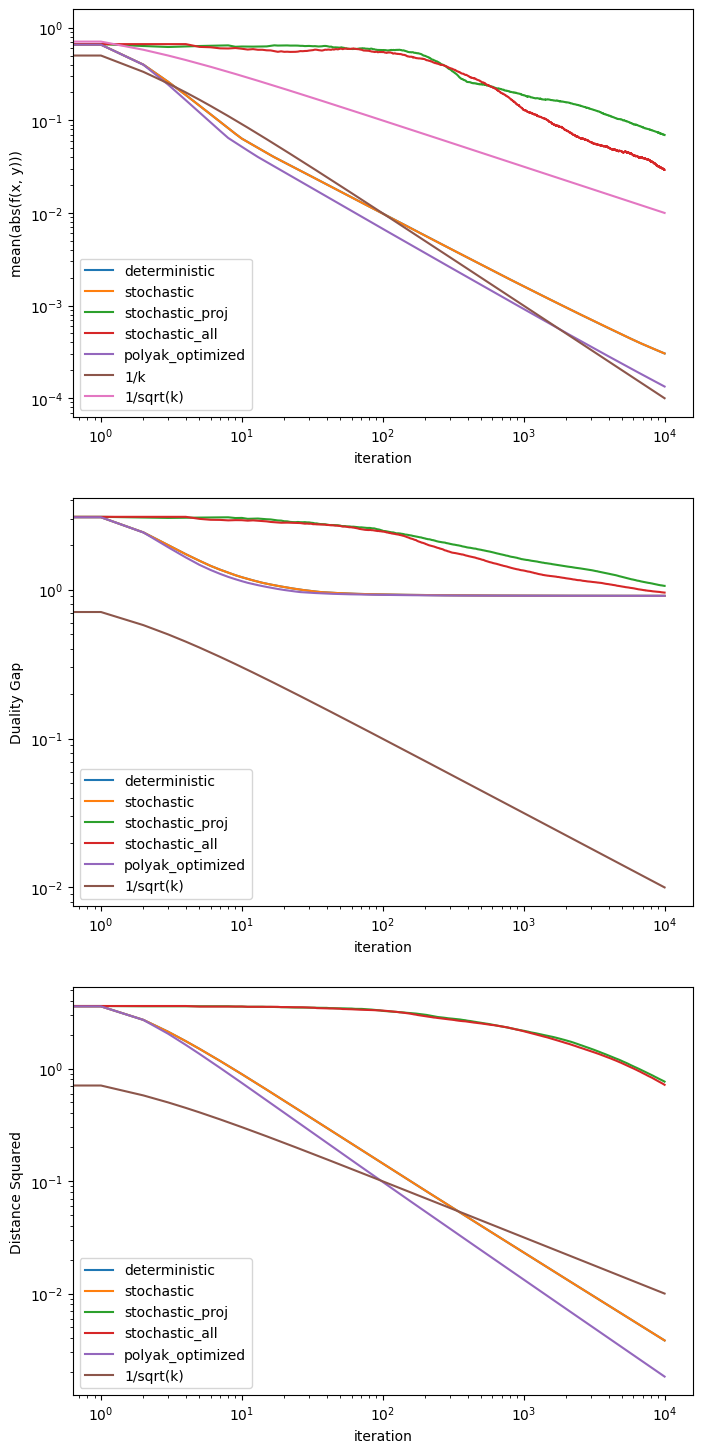

In [ ]:
fig, axes = plt.subplots(figsize=(8, 18), nrows=3, ncols=1)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(stats[name]['losses'], label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1]) for duality_gap in stats[name]['duality_gaps']], label=name)
    axes[2].plot(stats[name]['distances_squared'], label=name)

axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[1].set_ylabel('Duality Gap')
axes[2].set_ylabel('Distance Squared')

for ax in axes:
    ax.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='1/sqrt(k)')
    ax.set_xlabel('iteration')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.show()

In [ ]:
MD_optim.oracle(A, Xs[-1], Ys[-1], MD_optim.scheduler())
Xs[-1].sum(), Ys[-1].sum()
optimal_duality_gap
# x_opt = np.linalg.solve(A, np.ones(m) / m)
# y_opt = np.linalg.solve(A.T, np.ones(n) / n)
# x_opt = np.exp(x_opt) / np.linalg.norm(np.exp(x_opt), ord=1)
# y_opt = np.exp(y_opt) / np.linalg.norm(np.exp(y_opt), ord=1)

# dg = duality_gap(A, x_opt, y_opt) 
# dg[0] - dg[1], x_opt, y_opt

0.8862131219906444

In [ ]:
np.min(stats[name]['losses'] - optimal_loss - np.min(stats[name]['losses'] - optimal_loss))

0.0

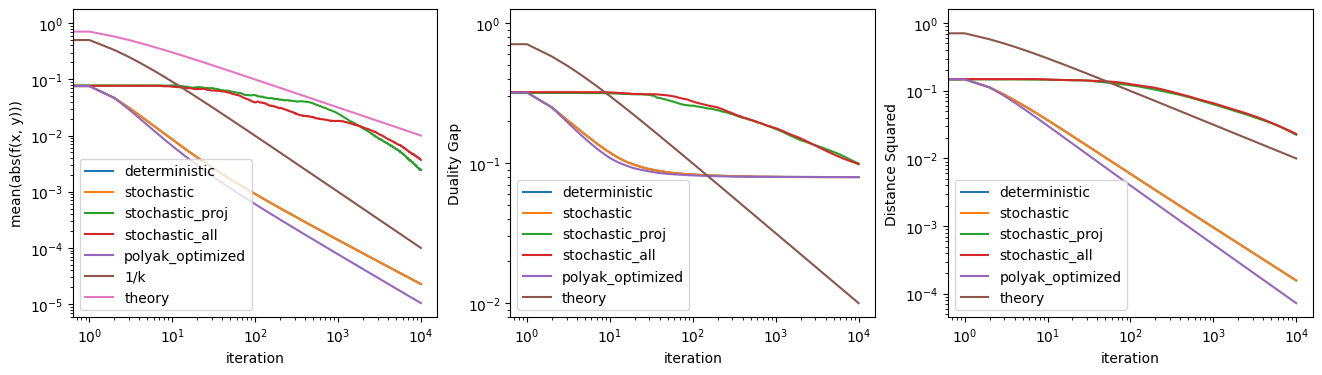

In [ ]:
fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=3)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(np.abs(stats[name]['losses']), label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1])  for duality_gap in stats[name]['duality_gaps']], label=name)
    axes[2].plot(stats[name]['distances_squared'], label=name)

axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[1].set_ylabel('Duality Gap')
axes[2].set_ylabel('Distance Squared')

for ax in axes:
    ax.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
    ax.set_xlabel('iteration')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.show()

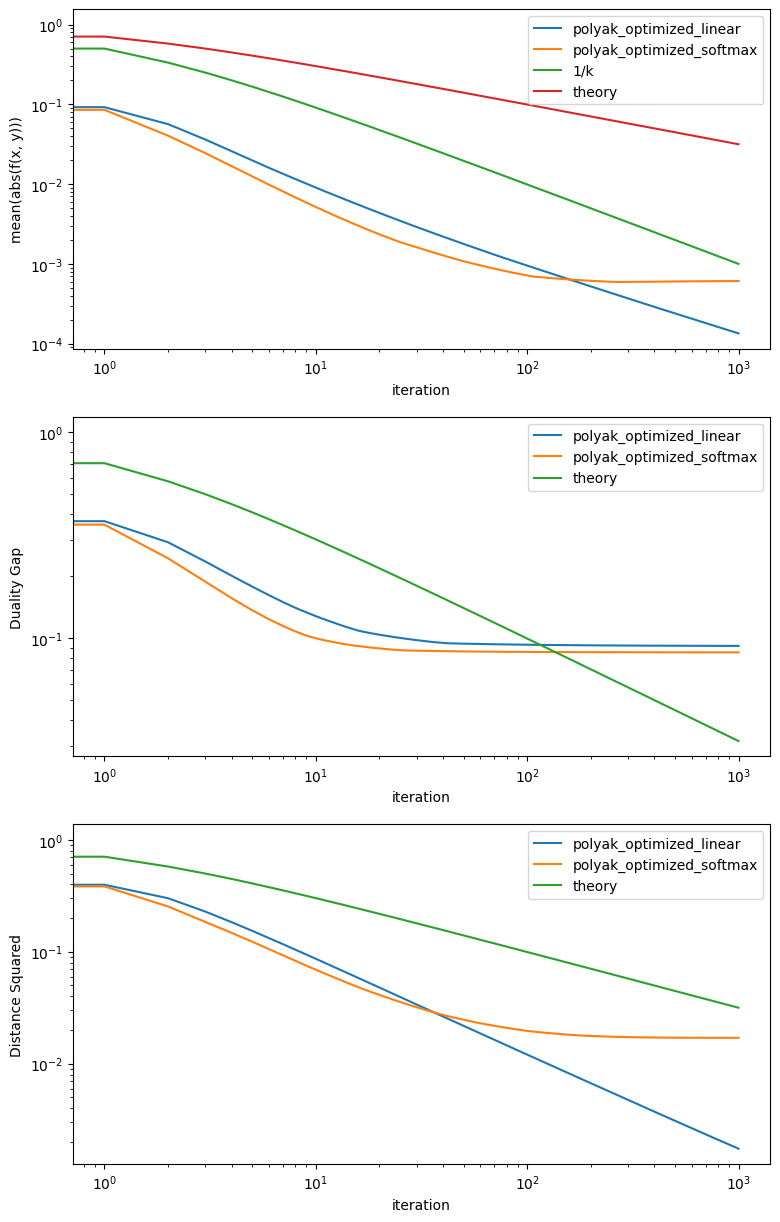

In [ ]:
m, n = 10, 10
n_starts = 10
m_starts = 10
max_steps = 1000

x_opt, y_opt = np.ones(n) / n, np.ones(m) / m
optimal_loss, optimal_duality_gap = 0., 0.

params_grid = {
    'polyak_optimized_linear': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps, 'polyak_optimized': True, 'softmax_proj': False},
    'polyak_optimized_softmax': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps, 'polyak_optimized': True, 'softmax_proj': True},
    'polyak_optimized_softmax': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps, 'polyak_optimized': True, 'linear_proj': False}
}

stats = {}
for name, params in params_grid.items():
    length = params['max_steps'] + 1
    stats[name] = {
        'losses': [0. for _ in range(length)],
        'duality_gaps': [[0., 0.] for _ in range(length)],
        'distances_squared': [0. for _ in range(length)]
    }

for _ in range(m_starts):
    A = np.random.normal(size=(m, n))
    dg = duality_gap(A, x_opt, y_opt)
    optimal_duality_gap = dg[0] - dg[1]
    optimal_loss = y_opt @ A @ x_opt

    for start in range(n_starts):
        x0, y0 = np.zeros(A.shape[1]), np.zeros(A.shape[0])
        x0[np.random.choice(x0.shape[0])] += 1.
        y0[np.random.choice(y0.shape[0])] += 1.

        for i, (name, params) in enumerate(params_grid.items()):
            method_losses = stats[name]['losses']
            method_duality_gaps = stats[name]['duality_gaps']
            method_d2s = stats[name]['distances_squared']

            MD_optim = SaddlePointMirrorDescentOptimizer(**params)
            Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0=x0, y0=y0)

            for j in range(len(cur_losses)):
                method_losses[j] += np.abs(cur_losses[j] - optimal_loss)
                method_duality_gaps[j][0] += cur_gaps[j][0]
                method_duality_gaps[j][1] += cur_gaps[j][1]
                method_d2s[j] += distance_squared(Xs[j], Ys[j], x_opt, y_opt)

    for i, (name, params) in enumerate(params_grid.items()):
        stats[name]['losses'] = [loss / n_starts for loss in stats[name]['losses']]
        stats[name]['duality_gaps'] = [[dg[0] / n_starts, dg[1] / n_starts] for dg in stats[name]['duality_gaps']]
        stats[name]['distances_squared'] = [d2 / n_starts for d2 in stats[name]['distances_squared']]

    # optimal_loss /= n_starts
    # optimal_duality_gap /= n_starts

for i, (name, params) in enumerate(params_grid.items()):
    stats[name]['losses'] = [loss / m_starts for loss in stats[name]['losses']]
    stats[name]['duality_gaps'] = [[dg[0] / m_starts, dg[1] / m_starts] for dg in stats[name]['duality_gaps']]
    stats[name]['distances_squared'] = [d2 / m_starts for d2 in stats[name]['distances_squared']]



fig, axes = plt.subplots(figsize=(9, 15), nrows=3, ncols=1)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(stats[name]['losses'], label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1]) for duality_gap in stats[name]['duality_gaps']], label=name)
    axes[2].plot(stats[name]['distances_squared'], label=name)

axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[1].set_ylabel('Duality Gap')
axes[2].set_ylabel('Distance Squared')

for ax in axes:
    ax.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
    ax.set_xlabel('iteration')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.show()

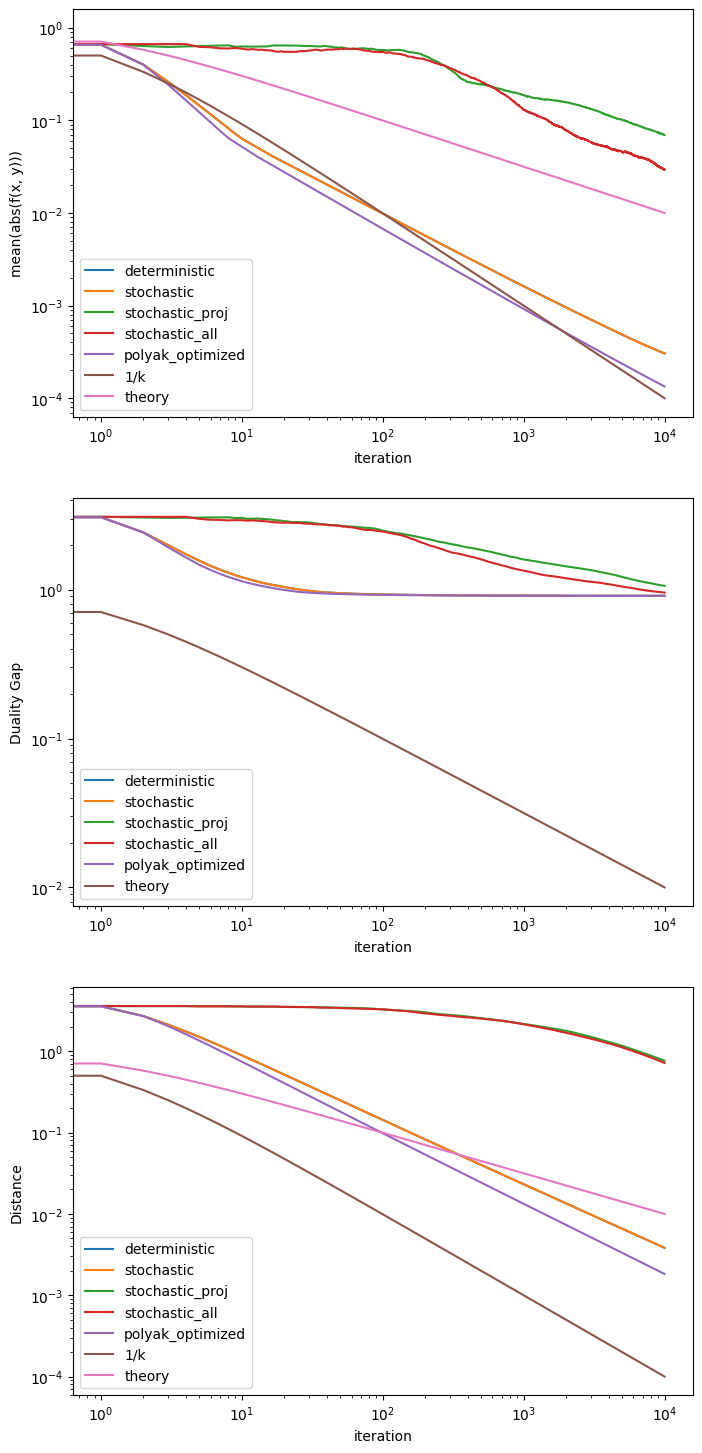

In [ ]:
n_starts = 10
m_starts = 1
max_steps = 10000

x_opt, y_opt = np.ones(n) / n, np.ones(m) / m
optimal_loss, optimal_duality_gap = 0., 0.

params_grid = {
    'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps},
    'polyak_optimized': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps, 'polyak_optimized': True}
}

stats = {}
for name, params in params_grid.items():
    length = params['max_steps'] + 1
    stats[name] = {
        'losses': [0. for _ in range(length)],
        'duality_gaps': [[0., 0.] for _ in range(length)],
        'distances_squared': [0. for _ in range(length)]
    }

for _ in range(m_starts):
    A = np.random.normal(size=(m, n))
    dg = duality_gap(A, x_opt, y_opt)
    optimal_duality_gap = dg[0] - dg[1]
    optimal_loss = y_opt @ A @ x_opt

    for start in range(n_starts):
        x0, y0 = np.zeros(A.shape[1]), np.zeros(A.shape[0])
        x0[np.random.choice(x0.shape[0])] += 1.
        y0[np.random.choice(y0.shape[0])] += 1.

        for i, (name, params) in enumerate(params_grid.items()):
            method_losses = stats[name]['losses']
            method_duality_gaps = stats[name]['duality_gaps']
            method_d2s = stats[name]['distances_squared']

            MD_optim = SaddlePointMirrorDescentOptimizer(**params)
            Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0=x0, y0=y0)

            for j in range(len(cur_losses)):
                method_losses[j] += np.abs(cur_losses[j] - optimal_loss)
                method_duality_gaps[j][0] += cur_gaps[j][0]
                method_duality_gaps[j][1] += cur_gaps[j][1]
                method_d2s[j] += distance_squared(Xs[j], Ys[j], x_opt, y_opt)

    for i, (name, params) in enumerate(params_grid.items()):
        stats[name]['losses'] = [loss / n_starts for loss in stats[name]['losses']]
        stats[name]['duality_gaps'] = [[dg[0] / n_starts, dg[1] / n_starts] for dg in stats[name]['duality_gaps']]
        stats[name]['distances_squared'] = [d2 / n_starts for d2 in stats[name]['distances_squared']]

    # optimal_loss /= n_starts
    # optimal_duality_gap /= n_starts

for i, (name, params) in enumerate(params_grid.items()):
    stats[name]['losses'] = [loss / m_starts for loss in stats[name]['losses']]
    stats[name]['duality_gaps'] = [[dg[0] / m_starts, dg[1] / m_starts] for dg in stats[name]['duality_gaps']]
    stats[name]['distances_squared'] = [d2 / m_starts for d2 in stats[name]['distances_squared']]



fig, axes = plt.subplots(figsize=(8, 18), nrows=3, ncols=1)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(stats[name]['losses'], label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1]) for duality_gap in stats[name]['duality_gaps']], label=name)
    axes[2].plot(stats[name]['distances_squared'], label=name)

axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[2].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[1].set_ylabel('Duality Gap')
axes[2].set_ylabel('Distance')

for ax in axes:
    ax.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
    ax.set_xlabel('iteration')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.show()

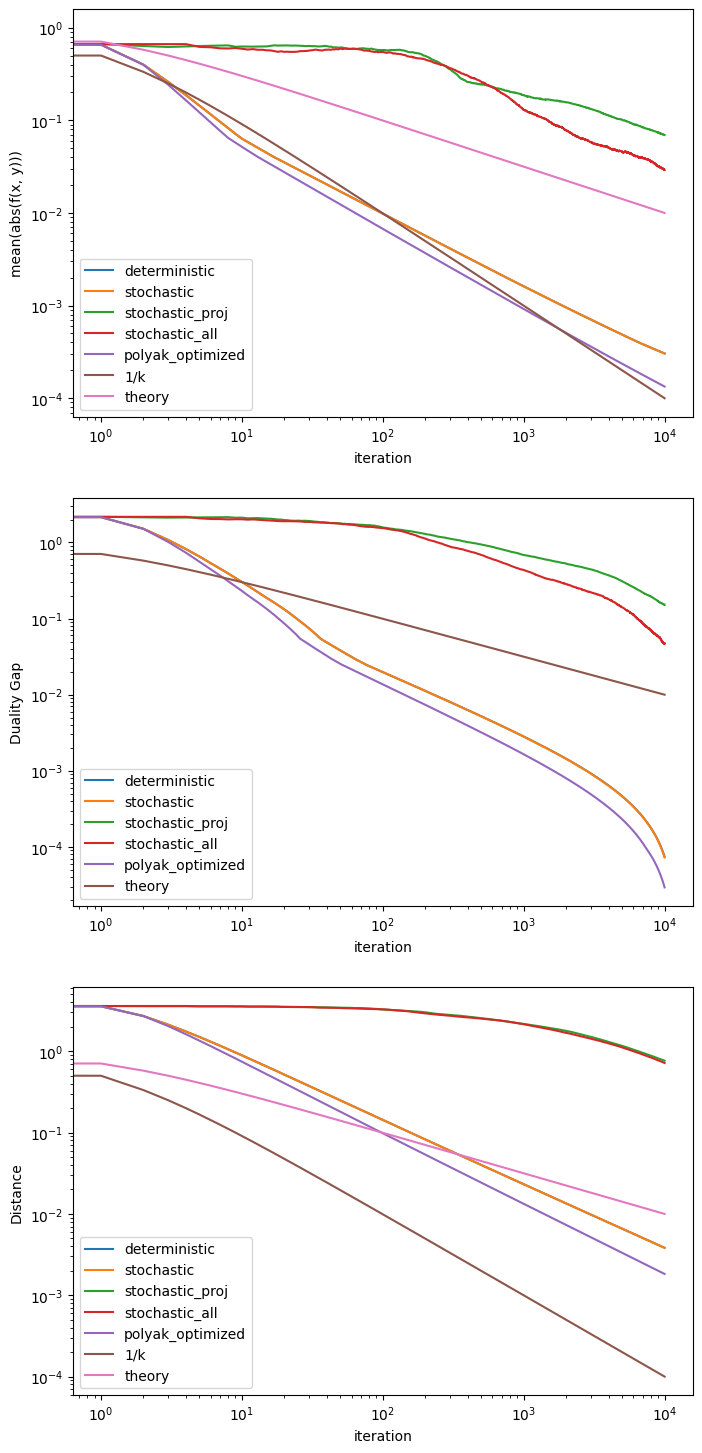

In [ ]:
fig, axes = plt.subplots(figsize=(8, 18), nrows=3, ncols=1)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(stats[name]['losses'], label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1] - optimal_duality_gap) for duality_gap in stats[name]['duality_gaps']], label=name)
    axes[2].plot(stats[name]['distances_squared'], label=name)

axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[2].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[1].set_ylabel('Duality Gap')
axes[2].set_ylabel('Distance')

for ax in axes:
    ax.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
    ax.set_xlabel('iteration')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.show()

In [ ]:
Xs[-1], Ys[-1]

(array([0.1000004 , 0.10042832, 0.09996922, 0.09995822, 0.09991883,
        0.09994091, 0.09987194, 0.09992233, 0.10005614, 0.09993369]),
 array([0.1000518 , 0.09992613, 0.09996254, 0.10006678, 0.10044355,
        0.09997296, 0.10000846, 0.09994769, 0.09980369, 0.09981639]))

In [ ]:
np.linalg.norm(np.hstack([Xs[-1], Ys[-1]]) - np.hstack(([x_opt, y_opt])))

0.02422766049201219

In [ ]:
np.argmax(A @ Xs[-1]), np.argmin(A.T @ Ys[-1]) 

x_dg, y_dg = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
gx, gy = MD_optim.deterministic_oracle(A, Xs[-1], Ys[-1] )

dg = duality_gap(A, Xs[-1], Ys[-1])
dg[0] - dg[1], gx @ (Xs[-1] - x_dg) + gy @ (Ys[-1] - y_dg)

distance_squared

(0.8816270232156617, 0.8816270232156617)

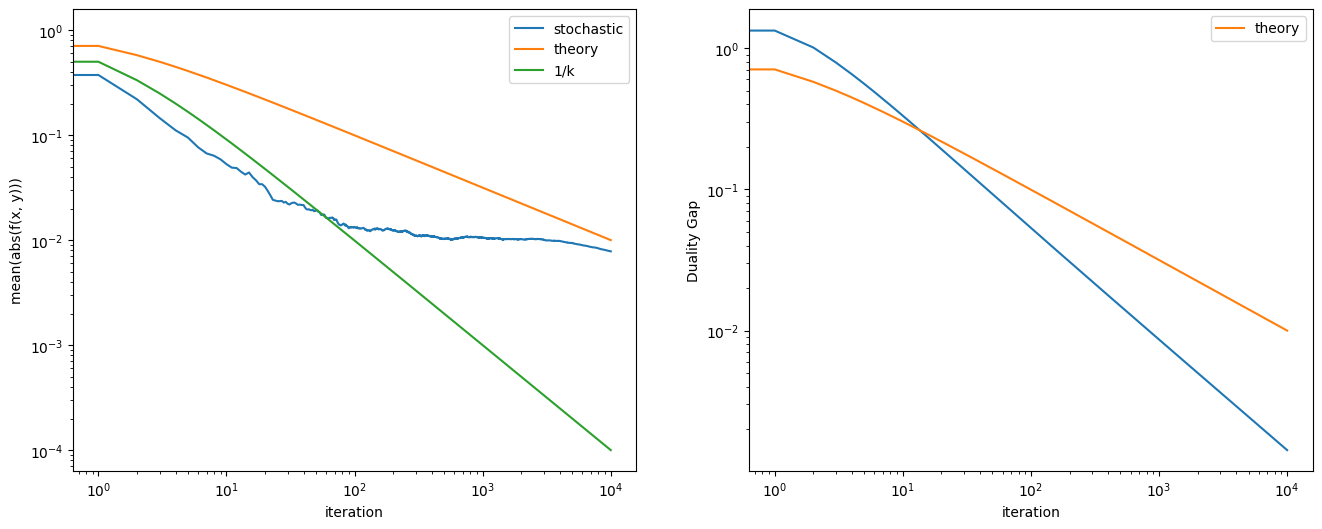

In [ ]:
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(np.abs(losses[name] - optimal_loss), label=name)
    # axes[1].plot([np.abs(duality_gap[0] - duality_gap[1] - optimal_duality_gap) for duality_gap in duality_gaps[name]], label=name)
    axes[1].plot([np.linalg.norm(np.hstack([x, y]) - np.hstack(([x_opt, y_opt]))) for x, y in zip(Xs, Ys)], label='')

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()

In [ ]:
def generateCycle(n: int, prob_to_right: float) -> scipy.sparse.csr_matrix:
    '''
    Computes PageRank matrix for cyclic-graphs
    :param prob_to_right: probability of going to the right node in the cycle
    :return: P - transition probability matrix in the scipy csr format
    '''
    prob_stay = 0.5
    prob_to_left = 0.5 - prob_to_right

    P = scipy.sparse.csr_matrix((n, n))
    for i in range(n):
        P[(i - 1) % n, i] = prob_to_left
        P[i, i] = prob_stay
        P[(i + 1) % n, i] = prob_to_right

    return P


def castPageRankMatrix(P):
    B = P.T - scipy.sparse.eye(P.shape[0])
    
    zeros = scipy.sparse.csr_matrix(P.shape)
    ones = np.ones((P.shape[0], 1))
    
    A = scipy.sparse.vstack([
        scipy.sparse.hstack([zeros, B, -ones]),
        scipy.sparse.hstack([-B.T, zeros, ones]),
        scipy.sparse.hstack([ones.T, -ones.T, 0])
    ])

    return scipy.sparse.csr_matrix(A)

In [ ]:
P = generateCycle(5, 0.25)
A = castPageRankMatrix(P).toarray()
print(A)

[[ 0.    0.    0.    0.    0.   -0.5   0.25  0.    0.    0.25 -1.  ]
 [ 0.    0.    0.    0.    0.    0.25 -0.5   0.25  0.    0.   -1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.25 -0.5   0.25  0.   -1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.25 -0.5   0.25 -1.  ]
 [ 0.    0.    0.    0.    0.    0.25  0.    0.    0.25 -0.5  -1.  ]
 [ 0.5  -0.25  0.    0.   -0.25  0.    0.    0.    0.    0.    1.  ]
 [-0.25  0.5  -0.25  0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.   -0.25  0.5  -0.25  0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.   -0.25  0.5  -0.25  0.    0.    0.    0.    0.    1.  ]
 [-0.25  0.    0.   -0.25  0.5   0.    0.    0.    0.    0.    1.  ]
 [ 1.    1.    1.    1.    1.   -1.   -1.   -1.   -1.   -1.    0.  ]]


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


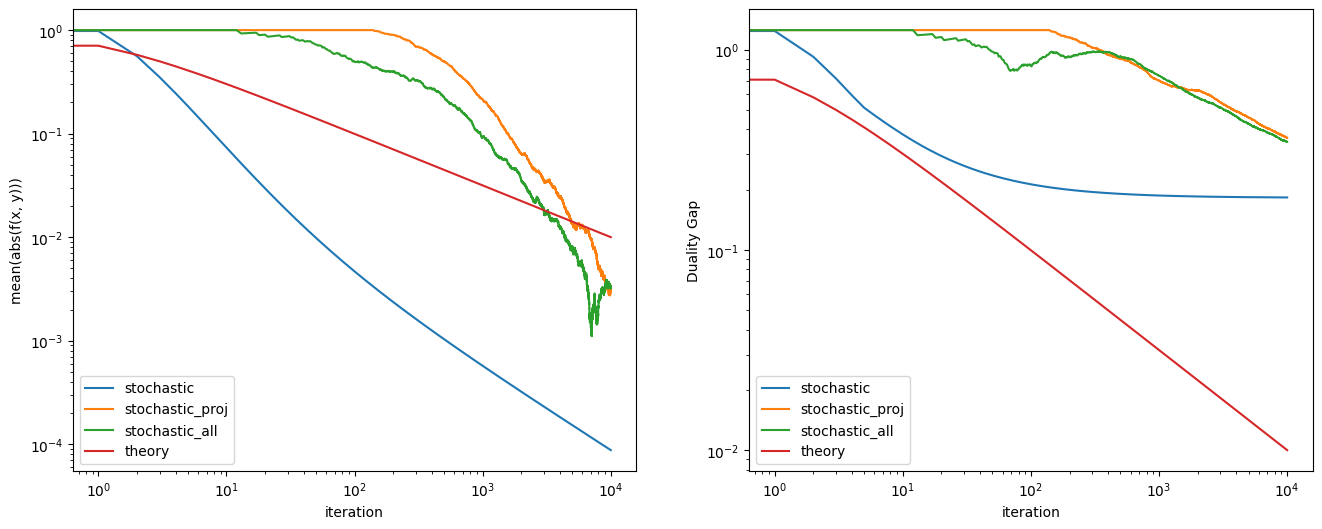

In [ ]:
x0=np.zeros(A.shape[1])
y0=np.zeros(A.shape[0])
x0[-1] = 1.
y0[6] = 1.

max_steps = 10000

params_grid = {
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps},
}

fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

for i, (name, params) in enumerate(params_grid.items()):
    MD_optim = SaddlePointMirrorDescentOptimizer(**params)
    Xs, Ys, losses = MD_optim.fit(A, x0, y0)
    duality_gaps = [duality_gap(A, x, y) for x, y in zip(Xs, Ys)]

    axes[0].plot(losses, label=name)
    axes[1].plot(duality_gaps, label=name)

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()

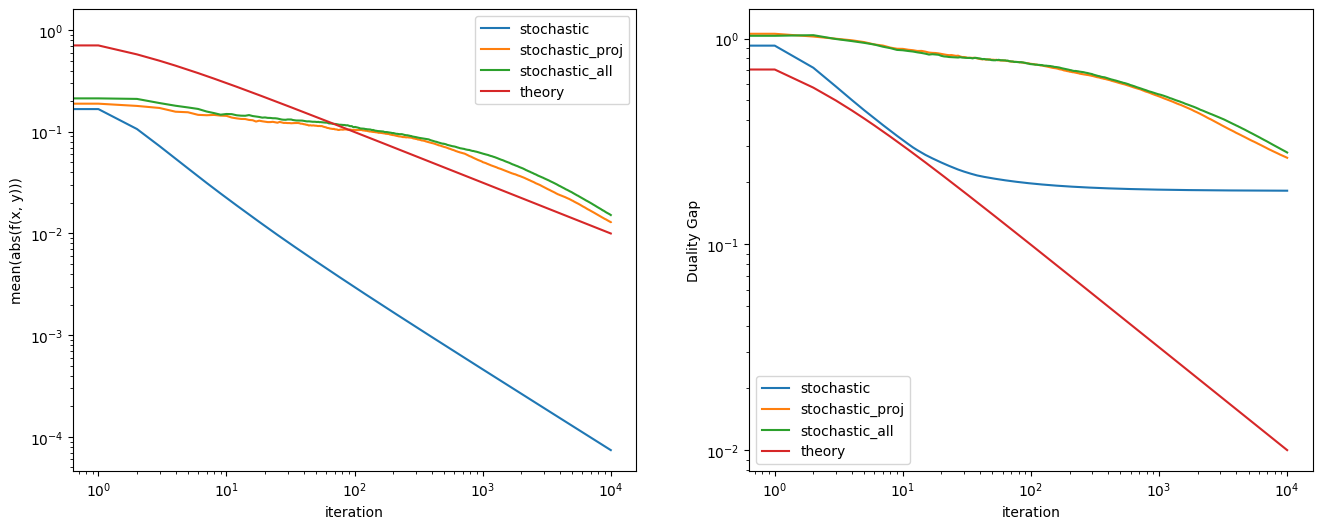

In [ ]:
n_starts = 100
max_steps = 10000

params_grid = {
    # 'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps},
}
losses = {
    # 'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)]
}
duality_gaps = {
    # 'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)]
}

fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

for start in range(n_starts):
    x0 = np.zeros(A.shape[1])
    y0 = np.zeros(A.shape[0])
    x0[np.random.choice(x0.shape[0])] += 0.8
    x0[np.random.choice(x0.shape[0])] += 0.1
    x0[np.random.choice(x0.shape[0])] += 0.1
    y0[np.random.choice(y0.shape[0])] += 0.8
    y0[np.random.choice(y0.shape[0])] += 0.1
    y0[np.random.choice(y0.shape[0])] += 0.1

    for i, (name, params) in enumerate(params_grid.items()):
        method_losses = losses[name]
        method_duality_gaps = duality_gaps[name]

        MD_optim = SaddlePointMirrorDescentOptimizer(**params)
        Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0, y0)

        for j in range(len(cur_losses)):
            method_losses[j] += np.abs(cur_losses[j])
            method_duality_gaps[j] += cur_gaps[j]

for i, (name, params) in enumerate(params_grid.items()):
    losses[name] = [loss / n_starts for loss in losses[name]]
    duality_gaps[name] = [dg / n_starts for dg in duality_gaps[name]]

    axes[0].plot(losses[name], label=name)
    axes[1].plot(duality_gaps[name], label=name)

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()


In [ ]:
Ys[-1].T @ A @ Xs[-1], duality_gap(A, Xs[-1], Ys[-1])

(0.00017543421358258497, 0.0001167945238442214)

In [ ]:
np.max(A @ Xs[-1]), np.min(A.T @ Ys[-1])

(0.0910578640934502, -0.09094106956960597)

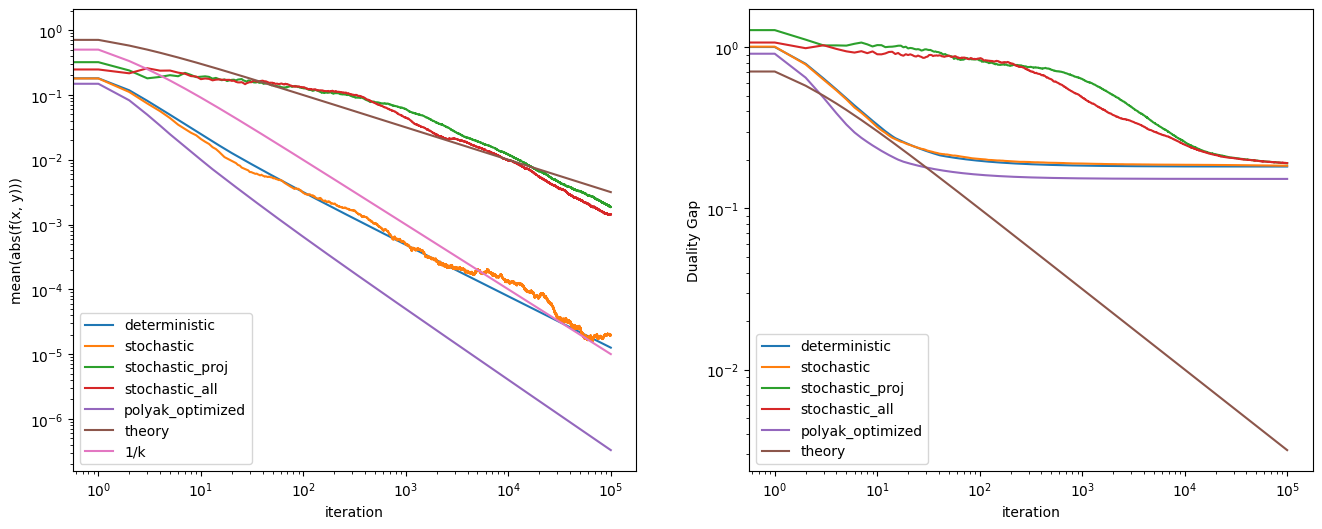

In [ ]:
n_starts = 10
max_steps = 100000

params_grid = {
    'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps, 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps, 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps, 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))},
    'polyak_optimized': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps, 'polyak_optimized': True, 'scheduler': ExponentialScheduler(lr=1., lr_mult=(1-1/max_steps))}
}
losses = {
    'deterministic': [0. for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [0. for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [0. for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [0. for _ in range(params_grid['stochastic_all']['max_steps'] + 1)],
    'polyak_optimized': [0. for _ in range(params_grid['polyak_optimized']['max_steps'] + 1)]
}
duality_gaps = {
    'deterministic': [[0., 0.] for _ in range(params_grid['deterministic']['max_steps'] + 1)],
    'stochastic': [[0., 0.] for _ in range(params_grid['stochastic']['max_steps'] + 1)],
    'stochastic_proj': [[0., 0.] for _ in range(params_grid['stochastic_proj']['max_steps'] + 1)],
    'stochastic_all': [[0., 0.] for _ in range(params_grid['stochastic_all']['max_steps'] + 1)],
    'polyak_optimized': [[0., 0.] for _ in range(params_grid['polyak_optimized']['max_steps'] + 1)]
}

fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)

for start in range(n_starts):
    x0 = np.zeros(A.shape[1])
    y0 = np.zeros(A.shape[0])
    x0[np.random.choice(x0.shape[0])] += 0.8
    x0[np.random.choice(x0.shape[0])] += 0.1
    x0[np.random.choice(x0.shape[0])] += 0.1
    y0[np.random.choice(y0.shape[0])] += 0.8
    y0[np.random.choice(y0.shape[0])] += 0.1
    y0[np.random.choice(y0.shape[0])] += 0.1

    for i, (name, params) in enumerate(params_grid.items()):
        method_losses = losses[name]
        method_duality_gaps = duality_gaps[name]

        MD_optim = SaddlePointMirrorDescentOptimizer(**params)
        Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0, y0)

        for j in range(len(cur_losses)):
            method_losses[j] += np.abs(cur_losses[j])
            method_duality_gaps[j][0] += cur_gaps[j][0]
            method_duality_gaps[j][1] += cur_gaps[j][1]

for i, (name, params) in enumerate(params_grid.items()):
    losses[name] = [loss / n_starts for loss in losses[name]]
    duality_gaps[name] = [[dg[0] / n_starts, dg[1] / n_starts] for dg in duality_gaps[name]]

    axes[0].plot(losses[name], label=name)
    axes[1].plot([duality_gap[0] - duality_gap[1] for duality_gap in duality_gaps[name]], label=name)

axes[0].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[0].set_xlabel('iteration')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
axes[1].set_ylabel('Duality Gap')
axes[1].set_xlabel('iteration')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()


In [ ]:
MD_optim.scheduler.lr_mult

0.999

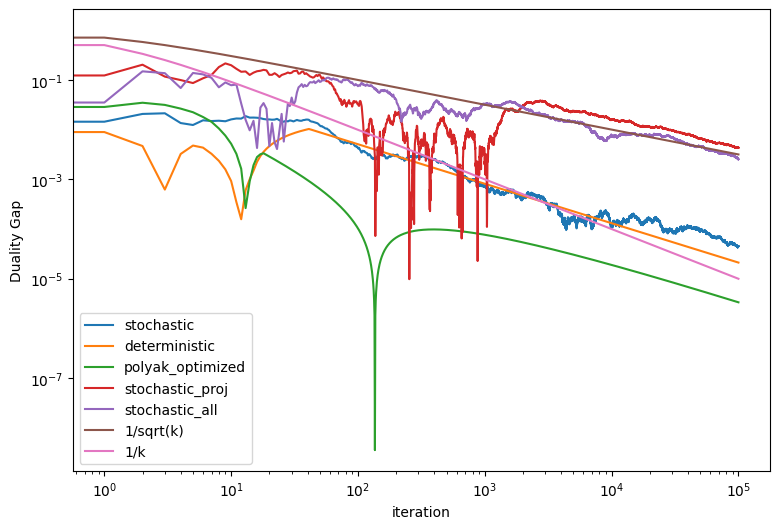

In [ ]:
fig, axes = plt.subplots(figsize=(9, 6), nrows=1, ncols=1)

plt.plot(np.abs([duality_gap[0] + duality_gap[1] for duality_gap in duality_gaps['stochastic']]), label='stochastic')
plt.plot(np.abs([duality_gap[0] + duality_gap[1] for duality_gap in duality_gaps['deterministic']]), label='deterministic')
plt.plot(np.abs([duality_gap[0] + duality_gap[1] for duality_gap in duality_gaps['polyak_optimized']]), label='polyak_optimized')
plt.plot(np.abs([duality_gap[0] + duality_gap[1] for duality_gap in duality_gaps['stochastic_proj']]), label='stochastic_proj')
plt.plot(np.abs([duality_gap[0] + duality_gap[1] for duality_gap in duality_gaps['stochastic_all']]), label='stochastic_all')
plt.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='1/sqrt(k)')
plt.plot([1/k for k in range(1, max_steps + 1)], label='1/k')

# plt.plot(np.abs([duality_gap[0] for duality_gap in duality_gaps['stochastic']]))
# plt.plot(np.abs([duality_gap[1] for duality_gap in duality_gaps['stochastic']]))

plt.xscale('log')
plt.yscale('log')

plt.xlabel('iteration')
plt.ylabel('Duality Gap')

plt.legend()
plt.show()

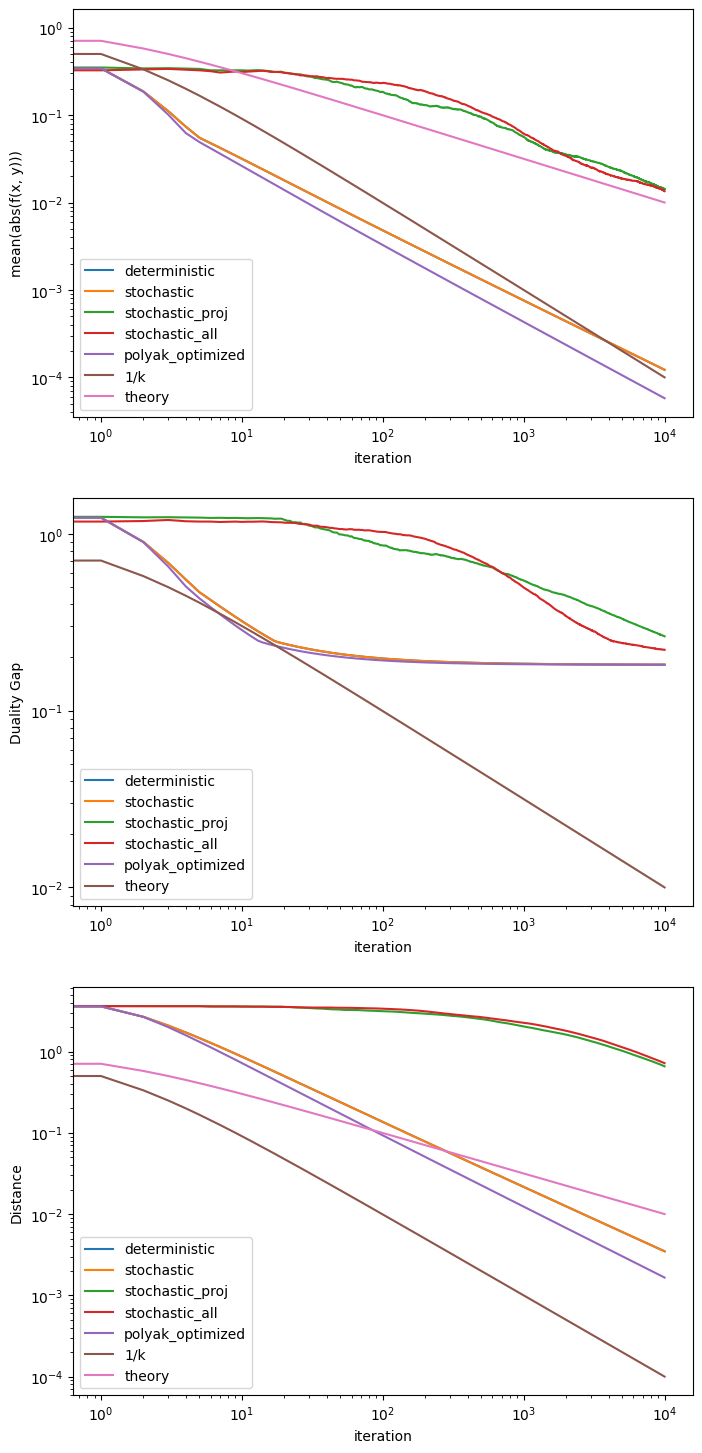

In [ ]:
n_starts = 10
m_starts = 1
max_steps = 10000
m, n = A.shape

x_opt, y_opt = np.ones(n) / n, np.ones(m) / m
optimal_loss, optimal_duality_gap = 0., 0.

params_grid = {
    'deterministic': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic': {'stochastic': True, 'stochastic_projection': False, 'max_steps': max_steps},
    'stochastic_proj': {'stochastic': False, 'stochastic_projection': True, 'max_steps': max_steps},
    'stochastic_all': {'stochastic': True, 'stochastic_projection': True, 'max_steps': max_steps},
    'polyak_optimized': {'stochastic': False, 'stochastic_projection': False, 'max_steps': max_steps, 'polyak_optimized': True}
}

stats = {}
for name, params in params_grid.items():
    length = params['max_steps'] + 1
    stats[name] = {
        'losses': [0. for _ in range(length)],
        'duality_gaps': [[0., 0.] for _ in range(length)],
        'distances_squared': [0. for _ in range(length)]
    }

for _ in range(m_starts):
    dg = duality_gap(A, x_opt, y_opt)
    optimal_duality_gap = dg[0] - dg[1]
    optimal_loss = y_opt @ A @ x_opt

    for start in range(n_starts):
        x0, y0 = np.zeros(A.shape[1]), np.zeros(A.shape[0])
        x0[np.random.choice(x0.shape[0])] += 1.
        y0[np.random.choice(y0.shape[0])] += 1.

        for i, (name, params) in enumerate(params_grid.items()):
            method_losses = stats[name]['losses']
            method_duality_gaps = stats[name]['duality_gaps']
            method_d2s = stats[name]['distances_squared']

            MD_optim = SaddlePointMirrorDescentOptimizer(**params)
            Xs, Ys, cur_losses, cur_gaps = MD_optim.fit(A, x0=x0, y0=y0)

            for j in range(len(cur_losses)):
                method_losses[j] += np.abs(cur_losses[j] - optimal_loss)
                method_duality_gaps[j][0] += cur_gaps[j][0]
                method_duality_gaps[j][1] += cur_gaps[j][1]
                method_d2s[j] += distance_squared(Xs[j], Ys[j], x_opt, y_opt)

    for i, (name, params) in enumerate(params_grid.items()):
        stats[name]['losses'] = [loss / n_starts for loss in stats[name]['losses']]
        stats[name]['duality_gaps'] = [[dg[0] / n_starts, dg[1] / n_starts] for dg in stats[name]['duality_gaps']]
        stats[name]['distances_squared'] = [d2 / n_starts for d2 in stats[name]['distances_squared']]

    # optimal_loss /= n_starts
    # optimal_duality_gap /= n_starts

for i, (name, params) in enumerate(params_grid.items()):
    stats[name]['losses'] = [loss / m_starts for loss in stats[name]['losses']]
    stats[name]['duality_gaps'] = [[dg[0] / m_starts, dg[1] / m_starts] for dg in stats[name]['duality_gaps']]
    stats[name]['distances_squared'] = [d2 / m_starts for d2 in stats[name]['distances_squared']]



fig, axes = plt.subplots(figsize=(8, 18), nrows=3, ncols=1)

for i, (name, params) in enumerate(params_grid.items()):
    axes[0].plot(stats[name]['losses'], label=name)
    axes[1].plot([np.abs(duality_gap[0] - duality_gap[1]) for duality_gap in stats[name]['duality_gaps']], label=name)
    axes[2].plot(stats[name]['distances_squared'], label=name)

axes[0].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[2].plot([1/k for k in range(1, max_steps + 1)], label='1/k')
axes[0].set_ylabel('mean(abs(f(x, y)))')
axes[1].set_ylabel('Duality Gap')
axes[2].set_ylabel('Distance')

for ax in axes:
    ax.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='theory')
    ax.set_xlabel('iteration')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.show()

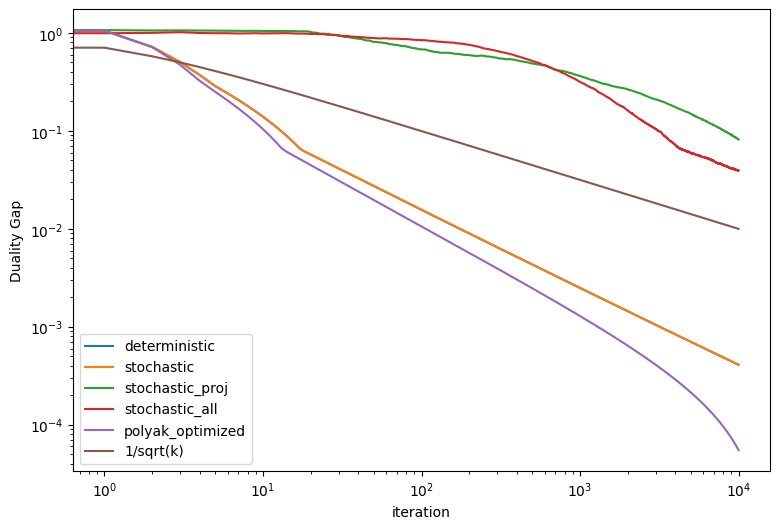

In [ ]:
fig, axes = plt.subplots(figsize=(9, 6), nrows=1, ncols=1)

for name in stats:
    plt.plot(np.abs([duality_gap[0] - duality_gap[1] - optimal_duality_gap for duality_gap in stats[name]['duality_gaps']]), label=name)

plt.plot([1/np.sqrt(k) for k in range(1, max_steps + 1)], label='1/sqrt(k)')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('iteration')
plt.ylabel('Duality Gap')

plt.legend()
plt.show()

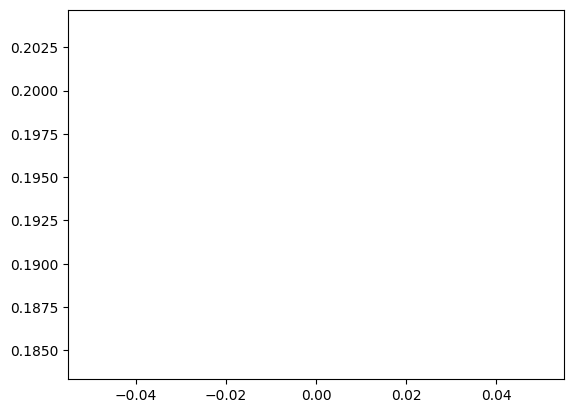

In [ ]:
plt.plot(losses['polyak_optimized'])

In [ ]:
Xs[-5:], Ys[-5:], Ys[-1] @ A @ Xs[-1]

([array([0.12491748, 0.0963289 , 0.10713214, 0.08892668, 0.06371912,
         0.0480144 , 0.11274382, 0.08892668, 0.08652596, 0.11904571,
         0.06371912]),
  array([0.12490498, 0.09631926, 0.10712142, 0.08891778, 0.06371274,
         0.0480096 , 0.11283257, 0.08891778, 0.0865173 , 0.11903381,
         0.06371274]),
  array([0.12489249, 0.09630963, 0.10711071, 0.08890889, 0.06370637,
         0.0480048 , 0.11282128, 0.08890889, 0.08650865, 0.11912191,
         0.06370637]),
  array([0.12498, 0.0963 , 0.1071 , 0.0889 , 0.0637 , 0.048  , 0.11281,
         0.0889 , 0.0865 , 0.11911, 0.0637 ]),
  array([0.1249675 , 0.09629037, 0.10708929, 0.08889111, 0.06369363,
         0.0479952 , 0.11279872, 0.0889911 , 0.08649135, 0.11909809,
         0.06369363])],
 [array([0.0753226 , 0.07502251, 0.11461438, 0.12064619, 0.11263379,
         0.12074622, 0.10953286, 0.07352206, 0.01860558, 0.09252776,
         0.08682605]),
  array([0.07531506, 0.075015  , 0.11460292, 0.12063413, 0.11262252,
      

In [ ]:
MD_optim.oracle(A, Xs[-1], Ys[-1], (1-1/max_steps) ** max_steps)

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.09196526, -0.18393052,  0.09196526,  0.        ,  0.        ,
        -0.36786105]),
 array([-0.        , -0.09196526,  0.18393052, -0.09196526, -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.36786105]))

In [ ]:
A

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.5 ,  0.25,  0.  ,  0.  ,
         0.25, -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25, -0.5 ,  0.25,  0.  ,
         0.  , -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25, -0.5 ,  0.25,
         0.  , -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25, -0.5 ,
         0.25, -1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25,  0.  ,  0.  ,  0.25,
        -0.5 , -1.  ],
       [ 0.5 , -0.25,  0.  ,  0.  , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ],
       [-0.25,  0.5 , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ],
       [ 0.  , -0.25,  0.5 , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ],
       [ 0.  ,  0.  , -0.25,  0.5 , -0.25,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ],
       [-0.25,  0.  ,  0.  , -0.25,  0.5 ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  , -1.  , -1.  , -1.

In [ ]:
duality_gaps['stochastic'][-1][0], duality_gaps['stochastic'][-1][1]

(0.09110101829847846, -0.09101241254507328)

In [ ]:
np.max(A @ (np.ones(A.shape[1]) / A.shape[1])) + np.min(A.T @ (np.ones(A.shape[0]) / A.shape[0]))

0.0

In [ ]:
A.shape

(11, 11)

In [ ]:
x_opt = np.linalg.solve(A, np.ones(A.shape[1]) / A.shape[1])
y_opt = np.linalg.solve(A.T, np.ones(A.shape[1]) / A.shape[1])
x_opt = np.exp(x_opt) / np.linalg.norm(np.exp(x_opt), ord=1)
y_opt = np.exp(y_opt) / np.linalg.norm(np.exp(y_opt), ord=1)

dg = duality_gap(A, x_opt, y_opt) 
dg[0] - dg[1], x_opt, y_opt

(0.9021120954755915,
 array([0.11977945, 0.09041115, 0.08220053, 0.09073566, 0.11808635,
        0.09415984, 0.11141556, 0.13636772, 0.07486167, 0.08198208]),
 array([0.10331825, 0.10908498, 0.11141949, 0.09528086, 0.09724278,
        0.08921191, 0.10025396, 0.10680986, 0.09113641, 0.0962415 ]))